# tutorial 04

## partial-sky ABS pipeline with noise

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### read in maps

In [2]:
NSIDE = 128

map30 = hp.read_map('./data/TQU_30GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
map95 = hp.read_map('./data/TQU_95GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
map150 = hp.read_map('./data/TQU_150GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
mapcmb = hp.read_map('./data/TQU_CMB_r7.fits',field=[0],dtype=np.float64,verbose=0)

vmap30 = hp.read_map('./data/TQU_var_30GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
vmap95 = hp.read_map('./data/TQU_var_95GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
vmap150 = hp.read_map('./data/TQU_var_150GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)
vmap353 = hp.read_map('./data/TQU_var_353GHz_r7.fits',field=[0],dtype=np.float64,verbose=0)

print (map95.shape, map95.dtype)

(196608,) float64


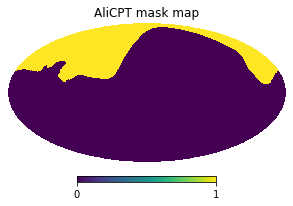

In [3]:
mask = hp.read_map('./data/ali_mask_r7.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

### simulate noise from variance maps and re-estimate $C_\ell^{noise}$, $\sigma_\ell^{noise}$

- generate a set of ''observables''

In [4]:
NPIX = 12*NSIDE**2

def noise_30():
    _tmp = np.zeros((NPIX))
    for i in range(NPIX):
        if mask[i]:
            _tmp[i] = np.random.normal(0,np.sqrt(vmap30[i]))
    return _tmp

def noise_95():
    _tmp = np.zeros((NPIX))
    for i in range(NPIX):
        if mask[i]:
            _tmp[i] = np.random.normal(0,np.sqrt(vmap95[i]))
    return _tmp

def noise_150():
    _tmp = np.zeros((NPIX))
    for i in range(NPIX):
        if mask[i]:
            _tmp[i] = np.random.normal(0,np.sqrt(vmap150[i]))
    return _tmp

def noise_353():
    _tmp = np.zeros((NPIX))
    for i in range(NPIX):
        if mask[i]:
            _tmp[i] = np.random.normal(0,np.sqrt(vmap353[i]))
    return _tmp

map30 += noise_30()
map95 += noise_95()
map150 += noise_150()
map353 += noise_353()

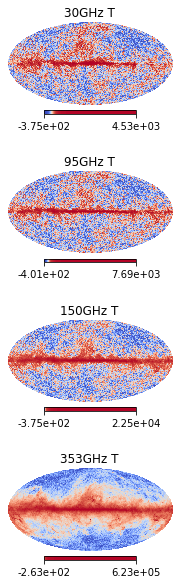

In [5]:
fig = matplotlib.pyplot.figure(figsize=(10,10))
gs = matplotlib.gridspec.GridSpec(55, 30)

fig.add_subplot(gs[0:10, 0:10])
hp.mollview(map30,format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='30GHz T',cbar=1)

fig.add_subplot(gs[15:25, 0:10])
hp.mollview(map95,format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='95GHz T',cbar=1)

fig.add_subplot(gs[30:40, 0:10])
hp.mollview(map150,format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='150GHz T',cbar=1)

fig.add_subplot(gs[45:55, 0:10])
hp.mollview(map353,format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='353GHz T',cbar=1)

- estimate cross PS

In [6]:
BINNING = 10
est = ap.pstimator(nside=NSIDE, mask=mask.reshape(1,-1), aposcale=1.0, psbin=BINNING)

auto_cmb = est.auto_t(mapcmb.reshape(1,-1))

auto_30 = est.auto_t(map30.reshape(1,-1))
auto_95 = est.auto_t(map95.reshape(1,-1))
auto_150 = est.auto_t(map150.reshape(1,-1))
auto_353 = est.auto_t(map353.reshape(1,-1))

cross_30_95 = est.cross_t(np.vstack([map30.reshape(1,-1),map95.reshape(1,-1)]))
cross_30_150 = est.cross_t(np.vstack([map30.reshape(1,-1),map150.reshape(1,-1)]))
cross_30_353 = est.cross_t(np.vstack([map30.reshape(1,-1),map353.reshape(1,-1)]))
cross_95_150 = est.cross_t(np.vstack([map95.reshape(1,-1),map150.reshape(1,-1)]))
cross_95_353 = est.cross_t(np.vstack([map95.reshape(1,-1),map353.reshape(1,-1)]))
cross_150_353 = est.cross_t(np.vstack([map150.reshape(1,-1),map353.reshape(1,-1)]))

In [7]:
Nfreq = 4  # 30,95,150,353
Llist = list(auto_cmb[0])
Nell = len(Llist)

tt_total = np.zeros((Nell,Nfreq,Nfreq))

for i in range(Nell):
    # diagnoal
    tt_total[i,0,0] = auto_30[1][i]
    tt_total[i,1,1] = auto_95[1][i]
    tt_total[i,2,2] = auto_150[1][i]
    tt_total[i,3,3] = auto_353[1][i]
    # cross
    tt_total[i,0,1] = cross_30_95[1][i]
    tt_total[i,0,2] = cross_30_150[1][i]
    tt_total[i,0,3] = cross_30_353[1][i]
    tt_total[i,1,2] = cross_95_150[1][i]
    tt_total[i,1,3] = cross_95_353[1][i]
    tt_total[i,2,3] = cross_150_353[1][i]
    tt_total[i,1,0] = tt_total[i,0,1]
    tt_total[i,2,0] = tt_total[i,0,2]
    tt_total[i,3,0] = tt_total[i,0,3]
    tt_total[i,2,1] = tt_total[i,1,2]
    tt_total[i,3,1] = tt_total[i,1,3]
    tt_total[i,3,2] = tt_total[i,2,3]

- Gaussian noise resampling

In [8]:
RESAMP = 5  # size of resampling

n30 = np.zeros((NPIX,RESAMP))
n95 = np.zeros((NPIX,RESAMP))
n150 = np.zeros((NPIX,RESAMP))
n353 = np.zeros((NPIX,RESAMP))

for i in range(NPIX):
    if mask[i]:
        n30[i,:] = np.random.normal(0,np.sqrt(vmap30[i]),RESAMP)
        n95[i,:] = np.random.normal(0,np.sqrt(vmap95[i]),RESAMP)
        n150[i,:] = np.random.normal(0,np.sqrt(vmap150[i]),RESAMP)
        n353[i,:] = np.random.normal(0,np.sqrt(vmap353[i]),RESAMP)

- estimate $C_\ell^{noise}$, $\sigma_\ell^{noise}$

In [9]:
auto_n30 = np.zeros((Nell))
sigma_n30 = np.zeros((Nell))
auto_n95 = np.zeros((Nell))
sigma_n95 = np.zeros((Nell))
auto_n150 = np.zeros((Nell))
sigma_n150 = np.zeros((Nell))
auto_n353 = np.zeros((Nell))
sigma_n353 = np.zeros((Nell))
cross_n3095 = np.zeros((Nell))
cross_n30150 = np.zeros((Nell))
cross_n30353 = np.zeros((Nell))
cross_n95150 = np.zeros((Nell))
cross_n95353 = np.zeros((Nell))
cross_n150353 = np.zeros((Nell))

for i in range(RESAMP):
    _tmp = est.auto_t(n30[:,i].reshape(1,-1))
    auto_n30 += _tmp[1]
    sigma_n30 += np.array(_tmp[1])*np.array(_tmp[1])
    
    _tmp = est.auto_t(n95[:,i].reshape(1,-1))
    auto_n95 += _tmp[1]
    sigma_n95 += np.array(_tmp[1])*np.array(_tmp[1])
    
    _tmp = est.auto_t(n150[:,i].reshape(1,-1))
    auto_n150 += _tmp[1]
    sigma_n150 += np.array(_tmp[1])*np.array(_tmp[1])
    
    _tmp = est.auto_t(n353[:,i].reshape(1,-1))
    auto_n353 += _tmp[1]
    sigma_n353 += np.array(_tmp[1])*np.array(_tmp[1])
    
    _tmp = est.cross_t(np.vstack([n30[:,i].reshape(1,-1),n95[:,i].reshape(1,-1)]))
    cross_n3095 += _tmp[1]
    
    _tmp = est.cross_t(np.vstack([n30[:,i].reshape(1,-1),n150[:,i].reshape(1,-1)]))
    cross_n30150 += _tmp[1]
    
    _tmp = est.cross_t(np.vstack([n30[:,i].reshape(1,-1),n353[:,i].reshape(1,-1)]))
    cross_n30353 += _tmp[1]
    
    _tmp = est.cross_t(np.vstack([n95[:,i].reshape(1,-1),n150[:,i].reshape(1,-1)]))
    cross_n95150 += _tmp[1]
    
    _tmp = est.cross_t(np.vstack([n95[:,i].reshape(1,-1),n353[:,i].reshape(1,-1)]))
    cross_n95353 += _tmp[1]
    
    _tmp = est.cross_t(np.vstack([n150[:,i].reshape(1,-1),n353[:,i].reshape(1,-1)]))
    cross_n150353 += _tmp[1]
#
auto_n30 /= RESAMP
sigma_n30 = np.sqrt(sigma_n30/RESAMP - auto_n30**2)
auto_n95 /= RESAMP
sigma_n95 = np.sqrt(sigma_n95/RESAMP - auto_n95**2)
auto_n150 /= RESAMP
sigma_n150 = np.sqrt(sigma_n150/RESAMP - auto_n150**2) 
auto_n353 /= RESAMP
sigma_n353 = np.sqrt(sigma_n353/RESAMP - auto_n353**2)  
cross_n3095 /= RESAMP 
cross_n30150 /= RESAMP
cross_n30353 /= RESAMP
cross_n95150 /= RESAMP
cross_n95353 /= RESAMP
cross_n150353 /= RESAMP

In [10]:
tt_noise = np.zeros((Nell,Nfreq,Nfreq))
tt_sigma = np.zeros((Nell,Nfreq))

for i in range(Nell):
    # diagnoal
    tt_noise[i,0,0] = auto_n30[i]
    tt_noise[i,1,1] = auto_n95[i]
    tt_noise[i,2,2] = auto_n150[i]
    tt_noise[i,3,3] = auto_n353[i]
    
    tt_sigma[i,0] = sigma_n30[i]
    tt_sigma[i,1] = sigma_n95[i]
    tt_sigma[i,2] = sigma_n150[i]
    tt_sigma[i,3] = sigma_n353[i]
    # cross
    tt_noise[i,0,1] = cross_n3095[i]
    tt_noise[i,0,2] = cross_n30150[i]
    tt_noise[i,0,3] = cross_n30353[i]
    tt_noise[i,1,2] = cross_n95150[i]
    tt_noise[i,1,3] = cross_n95353[i]
    tt_noise[i,2,3] = cross_n150353[i]
    tt_noise[i,1,0] = tt_noise[i,0,1]
    tt_noise[i,2,0] = tt_noise[i,0,2]
    tt_noise[i,3,0] = tt_noise[i,0,3]
    tt_noise[i,2,1] = tt_noise[i,1,2]
    tt_noise[i,3,1] = tt_noise[i,1,3]
    tt_noise[i,3,2] = tt_noise[i,2,3]

### call the `abssep`

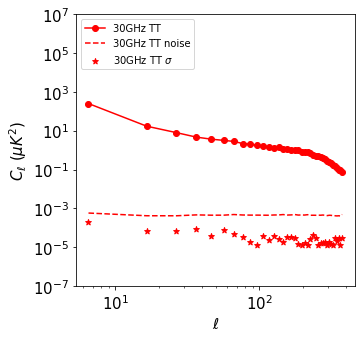

In [11]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(Llist,tt_total[:,0,0],
       color='red',marker='o',label='30GHz TT')
ax.plot(Llist,tt_noise[:,0,0],
        color='red',linestyle='--',label='30GHz TT noise')
ax.scatter(Llist,tt_sigma[:,0],
          color='red',marker='*',label='30GHz TT $\sigma$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$C_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_yscale('log')
ax.set_xscale('log')

(1, 384)

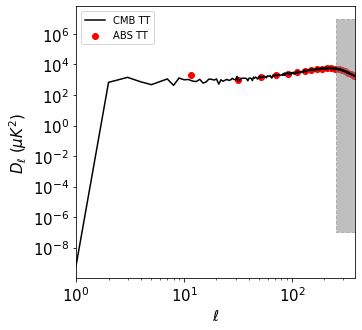

In [12]:
separator = ap.abssep(tt_total,tt_noise,tt_sigma,modes=Llist,bins=20,shift=10.,threshold=1.)
rslt_tt = separator()

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_tt[0],rslt_tt[1],
           color='red',marker='o',label=r'ABS TT')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(len(cmb_cl))
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl,
        color='black',linestyle='-',label=r'CMB TT')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
#ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

end